# Download packages and libraries

In [1]:
!pip install --upgrade pythainlp
!pip install emoji

     |████████████████████████████████| 8.9MB 3.3MB/s 
     |████████████████████████████████| 747kB 40.0MB/s 
     |████████████████████████████████| 51kB 2.3MB/s 
  Created wheel for emoji: filename=emoji-0.6.0-cp36-none-any.whl size=49716 sha256=21154c478161a6ac34bed369242b76fb31e8f473621b295164781916cdf20ba3
  Stored in directory: /root/.cache/pip/wheels/46/2c/8b/9dcf5216ca68e14e0320e283692dce8ae321cdc01e73e17796
Successfully built emoji


In [2]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
import emoji
from pythainlp.corpus.common import thai_stopwords
from pythainlp import sent_tokenize, word_tokenize
from pythainlp.ulmfit import *
from pythainlp.util import normalize
import re
import itertools
import dill as pickle
import pandas as pd

Corpus: wiki_lm_lstm
- Downloading: wiki_lm_lstm 0.32


100%|██████████| 1050919089/1050919089 [00:22<00:00, 45704426.82it/s]


Corpus: wiki_itos_lstm
- Downloading: wiki_itos_lstm 0.32


100%|██████████| 1530484/1530484 [00:00<00:00, 3783097.63it/s]


# Preprocessing & feature extraction



Text cleaning function

In [3]:
def text_cleaning(texts):
  clean_word = []
  stop_words = thai_stopwords() 
  for text in texts:
    #emoji list
    pos_emoji = re.compile(u'[\U0001F600\U0001F603\U0001F604\U0001F601\U0001F606\U0001F60A\U0000263A\U0000FE0F\U0001F923\U0001F642\U0001F609\U0001F60C\U0001F619\U0001F617\U0001F618\U0001F970\U0001F60D\U0001F61A\U0001F60B\U0001F61B\U0001F61D\U0001F61C\U0001F973\U0001F60F\U0001F633\U0001F638\U0001F63A\U0001F63D\U0001F63B\U0001F63C\U0001F44D\U0001F3FB\U0001F91F\U0001F3FB\U0001F918\U0001F3FB\U0001F48B\U00002764\U0000FE0F\U0001F9E1\U0001F49B\U0001F49A\U0001F499\U0001F49C\U00002763\U0000FE0F\U0001F495\U0001F49E\U0001F493\U0001F497\U0001F496\U0001F498\U0001F49D]',
            flags=re.UNICODE)
    neg_emoji = re.compile(u'[\U0001F494\U0001F642\U0001F643\U0001F61E\U0001F612\U0001F60F\U0001F614\U0001F61F\U0001F615\U0001F641\U00002639\U0000FE0F\U0001F623\U0001F616\U0001F62B\U0001F629\U0001F97A\U0001F622\U0001F62D\U0001F60F\U0001F624\U0001F620\U0001F621\U0001F92C\U0001F92F\U0001F975\U0001F628\U0001F630\U0001F625\U0001F613\U0001F925\U0001F636\U0001F610\U0001F611\U0001F644\U0001F626\U0001F640\U0001F63E\U0001F63C\U0001F595\U0001F3FB\U0001F44E\U0001F3FB\U0001F9B6\U0001F3FB\U0001F448\U0001F3FB\U0001F91E\U0001F3FB\U0001F44B\U0001F3FB\U0001F47F\U0001F47A\U0001F921\U0001F92E\U0001F974\U0001F463]',
            flags=re.UNICODE)
    pos_count = len(re.findall(pos_emoji,text))
    neg_count = len(re.findall(neg_emoji,text))
    #text.replace('☺️', 'posemo')
    #for emo in pos_emoji: text = text.replace(emo,'posemo')

    emoji_pattern = re.compile("["
                                u"\U0001F600-\U0001F64F"  # emoticons
                                u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                                u"\U0001F680-\U0001F6FF"  # transport & map symbols
                                u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                                u"\U00002500-\U00002BEF"  # chinese char
                                u"\U00002702-\U000027B0"
                                u"\U00002702-\U000027B0"
                                u"\U000024C2-\U0001F251"
                                u"\U0001f926-\U0001f937"
                                u"\U00010000-\U0010ffff"
                                u"\u2640-\u2642"
                                u"\u2600-\u2B55"
                                u"\u200d"
                                u"\u23cf"
                                u"\u23e9"
                                u"\u231a"
                                u"\ufe0f"  # dingbats
                                u"\u3030"
                                "]+", flags=re.UNICODE)
    text = emoji_pattern.sub(r"", text)
    #delte Link hashtag and mention
    text = re.sub(r"(?:@\S*|#\S*|http(?=.*://)\S*)", "",text)
    text = re.sub(r"^https://t.co/[A-Za-z0-9]*\s","",text)
    text = re.sub(r"\s+https://t.co/[a-zA-Z0-9]*\s", "", text)
    text = re.sub(r"\s+https://t.co/[a-zA-Z0-9]*$", "", text)
    #find and delete laugh
    laugh_count = len(re.findall(r'(5)\1{2,}(6?){3,}', text))
    text = re.sub(r'(5)\1{2,}(6?){3,}', '', text)
    #delete symbol
    text = re.sub(r'[!-@[-`{-~]',"",text)
    #text = re.sub("\d+", "", text) #number
    text = normalize(text)

    
#Tokenization

    tokens = process_thai(text)

#deletion of whitespace & one letter text

    i = 0;
    for token in list(tokens):
      if(len(token) == 1 or len(token) == token.count(token[0]) or token in ['xxrep','xxwrep','','ชา','นนท์','ปอนด์','ป้อม']):
        tokens.pop(i)
        i = i-1
      i = i+1

#Add thailaugh posemoji negemoji tag

    for a in range(laugh_count):
      tokens.append('thailaugh')
    for a in range(pos_count):
      tokens.append('posemoji')
    for a in range(neg_count):
      tokens.append('negemoji')
    
# POS Tag

    # from pythainlp.tag import pos_tag
    # pos = pos_tag(tokens,corpus='orchid_ud')
    # keep_tag = ['VERB', 'ADJ', 'ADV', 'INTJ', 'AUX']
    # #keep_tag = ['VACT','VATT','ADVN','ADVI','ADVP','ADVS','FIXV','NEG','ADJ','']
    
    
    # pos_tags = [t[0] for t in pos if (t[1] in keep_tag) or (t[0] == "thailaugh") 
    # or (t[0] == "posemoji")  or (t[0] == "negemoji")]
    # tokens = pos_tags

# Delete Stop Word

    filtered_sentence = []
    for t in tokens: 
      if t not in stop_words:
        #t = ''.join(c[0] for c in itertools.groupby(t))
        filtered_sentence.append(t)
    clean_word.append(','.join(filtered_sentence))
  return clean_word

In [4]:
data = pd.read_csv('/content/drive/My Drive/ICT senior project/Dataset_combination/dataset.csv',)
data.head()

,id,text,sentiment
0,0,อดเห็นชานนท์ชิมอาหารแล้ว😂 #masterchefallstarst...,1.0
1,1,เอาไรกับคนในพันติ๊บ คำที่พิมเหมือนนางร้ายนางอิ...,1.0
2,2,ต้องคิดถึงซีน’ชิม’ของพี่ชานนท์แน่ๆเลย มีทุกอี...,2.0
3,3,ร้องไห้กับพี่ชานู้ปปี้ #masterchefallstarsthai...,1.0
4,4,ชั้นรักพี่ปอนด์และรักพลังบวกนี้ แล้วทำให้ชั้นน...,2.0


In [5]:
clean_list = text_cleaning(data['text'])
new_list = []
for i in range(len(clean_list)):
  new_list.append([data['text'][i], clean_list[i]])
b_a = pd.DataFrame(new_list, columns=['before', 'after'])
b_a.head(10)

,before,after
0,อดเห็นชานนท์ชิมอาหารแล้ว😂 #masterchefallstarst...,"อด,ชิม,อาหาร"
1,เอาไรกับคนในพันติ๊บ คำที่พิมเหมือนนางร้ายนางอิ...,"คนใน,พัน,ติ๊บ,พิม,เหมือน,ร้าย,อิจฉา,เข้าไป,กด,..."
2,ต้องคิดถึงซีน’ชิม’ของพี่ชานนท์แน่ๆเลย มีทุกอี...,"คิดถึง,ซีน,ชิม,พี่,แน่ๆ,อี,พี,thailaugh"
3,ร้องไห้กับพี่ชานู้ปปี้ #masterchefallstarsthai...,"ร้องไห้,พี่,นู้ป,ปี้"
4,ชั้นรักพี่ปอนด์และรักพลังบวกนี้ แล้วทำให้ชั้นน...,"ชั้น,รัก,พี่,รัก,พลัง,บวก,ชั้น,นึก,พระ,ตา,มหา,..."
5,เชียร์มาตั้งแต่ต้นจนถึงวันนี้ เห็นความตั้งใจ อ...,"เชียร์,แต่ต้น,ความตั้งใจ,อดทน,เข้มแข็ง,ความอ่อ..."
6,@Pondmcss3 #MasterChefAllStarsThailandปอนด์พัฒ...,
7,แงงงงงวีคนี้พิหมีชานนท์คนหิวออก ม่ายยยยยยยยยย ...,"แง,วีค,พิ,หมี,คน,หิว,ม่าย"
8,เหมือนลุงข้างบ้านขิงกันอะ555555555555555555555...,"เหมือน,ลุง,บ้าน,ขิง,อะ,thailaugh"
9,ลุง : พี่กอล์ฟเอาเบค่อนป่าวให้ยืมแด๊ด : ให้ปะล...,"ลุง,พี่,กอล์ฟ,เบ,ป่าว,ให้ยืม,แด๊ด,ปะ,ละลุง,ปะ,..."


Create wordcloud

In [6]:
texts_list = [text.split(',') for text in clean_list]
words = [item for sublist in texts_list for item in sublist]
text = ' '.join(t for t in words)

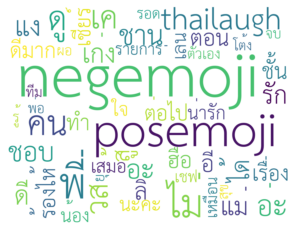

In [7]:
import matplotlib.pyplot as plt
from pythainlp.tokenize import word_tokenize
from wordcloud import WordCloud
from pythainlp.corpus.common import thai_stopwords
from pythainlp import word_tokenize

wordcloud = WordCloud(font_path='/content/drive/My Drive/ICT senior project/font/THSarabunNew.ttf',
                      stopwords = ' '.join(thai_stopwords()),
                      background_color="white",
                      width=1300,
                      height=1000,
                      collocations=False,
                      regexp=r"[\u0E00-\u0E7Fa-zA-Z']+",
                      max_words = 50
                      ).generate(' '.join(word_tokenize(text)))
plt.imshow(wordcloud, cmap=plt.cm.gray, interpolation='bilinear')
plt.axis("off")
plt.show()

In [ ]:
wordcloud.to_file('wordcloud.png')

# Training and Testing Split

In [8]:
X = clean_list
y = data['sentiment']

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=13)

# Feature Extraction (TFIDF)

In [10]:
tfidf = TfidfVectorizer(analyzer=lambda x:x.split(','))
X_train = tfidf.fit_transform(X_train)#####
#X = tfidf_fit.transform(word_list)

In [11]:
tfidf_feature = pd.DataFrame(X_train.todense(), columns=tfidf.get_feature_names()) ####

In [12]:
print(tfidf_feature.shape)
print(tfidf.get_feature_names())

(3684, 4478)
['', 'al', 'all', 'allstar', 'always', 'amp', 'and', 'android', 'application', 'attitude', 'awards', 'badcop', 'believe', 'belle', 'best', 'bnk', 'box', 'break', 'by', 'can', 'cg', 'chanon', 'chef', 'cinematography', 'clair', 'classic', 'collection', 'congratulations', 'cron', 'crying', 'ctw', 'cute', 'daddy', 'dark', 'day', 'de', 'delicious', 'delivery', 'denature', 'dish', 'dummy', 'enaak', 'energy', 'ep', 'epic', 'episode', 'event', 'extra', 'facebook', 'fast', 'fb', 'fc', 'fighting', 'film', 'fly', 'food', 'forever', 'friend', 'gdh', 'ged', 'gemez', 'ginorella', 'golftellmatar', 'gtgt', 'gtlt', 'gucci', 'guy', 'helene', 'hollywood', 'hormones', 'how', 'ibeesipr', 'ig', 'impact', 'ios', 'is', 'jah', 'jaonaay', 'join', 'keep', 'king', 'kingpower', 'lakorn', 'literally', 'love', 'lune', 'make', 'master', 'masterchef', 'masterchefallstarsthailand', 'materchef', 'me', 'medium', 'mera', 'mind', 'mindset', 'move', 'mtc', 'mv', 'mvp', 'mystery', 'na', 'nana', 'nananspk', 'nege

In [21]:
tfidf_feature.head()

,,al,all,allstar,always,amp,and,android,application,attitude,awards,badcop,believe,belle,best,bnk,box,break,by,can,cg,chanon,chef,cinematography,clair,classic,collection,congratulations,cron,crying,ctw,cute,daddy,dark,day,de,delicious,delivery,denature,dish,...,ไว้ใจ,ไส,ไส้,ไส้กรอก,ไห,ไหนว่า,ไหม,ไหม้,ไหล,ไหล่,ไหว,ไหว้,ไห่,ไห้,ไอ,ไอดอล,ไอเดีย,ไอ่,ไอ่คน,ไอ่ต้าว,ไอ้,ไฮ,ไๆ,ไ่ม่,ๅๆๆ,ๆคน,ๆจนพอ,ๆตลค,ๆน๊า,ๆป้ะ,ๆพอ,ๆๆๆเชฟ,ๆ“,์คน,์ป,์ย,ສູ້ໆເດີ,“ผมขอ,“เควส,•̀ᴗ•́و
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.394368,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
#feature_extraction[feature_extraction['dark'] != 0]


In [15]:
#import pickle

pickle.dump(tfidf, open("/content/drive/My Drive/ICT senior project/tfidf/tfidf.pickle", "wb"))
#pickle.dump(train_comment_features, open("train_comment_features.pickle", "wb"))
#pickle.dump(test_comment_features, open("test_comment_features.pickle", "wb"))

In [ ]:
#feature_extraction.to_csv('feature_extraction.csv')

# Feature selection



In [16]:
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import SelectPercentile
K = round(X_train.shape[0] / 10)
#P = 40
data_selection = SelectKBest(mutual_info_classif,k=K)
#data_selection = SelectPercentile(f_classif, percentile=P)
Xnew = data_selection.fit_transform(X_train, y_train)
Xnew.shape

(3684, 368)

In [17]:
score = pd.DataFrame([data_selection.scores_, tfidf_feature.columns])
score = score.transpose()
score.sort_values(0, ascending=False).head(10).transpose()

,104,1968,123,1043,457,164,3328,865,3198,3281
0,0.0986609,0.0879788,0.0718079,0.0602927,0.0602591,0.0558599,0.0432886,0.0428357,0.0415415,0.0411911
1,negemoji,พี่,posemoji,ดู,คน,thailaugh,เควส,ชอบ,อ่ะ,เก่ง


In [19]:
feature_selection = data_selection.get_support(indices=True)
pickle.dump(feature_selection, open("/content/drive/My Drive/ICT senior project/tfidf/feature.pickle", "wb"))

In [20]:
feature_name_new = list(tfidf_feature.columns[feature_selection])
data_frame = pd.DataFrame(Xnew.todense(), columns=feature_name_new)
data_frame.head()

,ep,king,negemoji,not,of,posemoji,pressure,shy,test,thailaugh,กดดัน,กรรมการ,กระดาษ,กรี๊ด,กลับมา,กลัว,กอด,กอล์ฟ,กะ,การเรียน,กำลังใจ,กิน,กี่,กุ,ขนาด,ขอบคุณ,ขอให้,ขา,ขำ,คน,คนดู,คนอื่น,คนเก่ง,คนเดียว,คนใน,ครอบครัว,ครู,ความคิด,ความน่ารัก,ความรัก,...,แม่,แย่,แรร์,แล้,แล้วก็,แอ,แอบ,โกง,โค,โคตร,โคมไฟ,โจทย์,โดน,โต้ง,โน่,โปรย,โรงเรียน,โว้ย,โอเค,โอ้ย,โอ๊ย,ใจ,ใส่,ได้ดี,ไทย,ไปดู,ไพฑูรย์,ไม่ต้อง,ไม่มี,ไม่รู้,ไม่เคย,ไม่เห็น,ไม่เอา,ไม่ได้,ไม่ไหว,ไหม,ไหล,ไหว้,ไอ,ไอ้
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.078299,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.211895,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.394368


In [ ]:
#support = data_selection.get_support(indices=True)
#support

In [ ]:
#data_frame.to_csv('/content/drive/My Drive/ICT senior project/dataset/feature_selection.csv')

# Testing Data

In [ ]:
X_test1 = tfidf.transform(X_test)[:,feature_selection]
#X_test = X_test[:,feature_selection]
X_train1 = Xnew

In [ ]:
pickle.dump(X_train1, open("/content/drive/My Drive/ICT senior project/train_test/X_train.pickle", "wb"))
pickle.dump(y_train, open("/content/drive/My Drive/ICT senior project/train_test/y_train.pickle", "wb"))
pickle.dump(X_test1, open("/content/drive/My Drive/ICT senior project/train_test/X_test.pickle", "wb"))
pickle.dump(y_test, open("/content/drive/My Drive/ICT senior project/train_test/y_test.pickle", "wb"))

In [ ]:
pickle.dump(X_train1, open("/content/drive/My Drive/ICT senior project/testing2/X_train.pickle", "wb"))
pickle.dump(y_train, open("/content/drive/My Drive/ICT senior project/testing2/y_train.pickle", "wb"))
pickle.dump(X_test1, open("/content/drive/My Drive/ICT senior project/testing2/X_test.pickle", "wb"))
pickle.dump(y_test, open("/content/drive/My Drive/ICT senior project/testing2/y_test.pickle", "wb"))